## Wave Equation Convergence
### 1. Methods

In [9]:
import numpy as np
import matplotlib.pylab as plt

In [10]:
def rhs(phi, pi, x, N, ng):
    """
    Performs the right hand side of the wave equation
    :param phi: solution at a time 't' (state vector)
    :param pi: 1st derivative of the solution (state vector)
    :param x: grid array (including ghosts)
    :param N: Number of physical points
    :param ng: Number of ghosts
    :return: dot_phi: derivative in time of the solution at time 't'
             dot_pi: 2nd derivative of the solution at a time 't'
    """

    n = N + 2*ng # total number of points
    phi_dot = np.zeros_like(x) # assign memory to the solution
    pi_dot = np.zeros_like(x) # assign memory to the solution
    _d2_phi = np.zeros_like(x) # temporary storage for 2nd derivative of phi

    dx = x[1] - x[0] # grid spacing
    idx = 1. / dx

    # boundary conditions -> filling ghosts [staggered grid]
    phi[0] = phi[n-3] # left boundary
    phi[n-1] = phi[2] # right boundary
    pi[0] = pi[n-3]
    pi[n-1] = pi[2]

    # compute the right hand side
    for i in range(ng, N+ng):
        _d2_phi[i] = idx * idx * (phi[i+1] + phi[i-1] - 2 * phi[i]) # finite differencing

        phi_dot[i] = pi[i]
        pi_dot[i] = _d2_phi[i]

    return (phi_dot, pi_dot)

In [11]:
def rk4(phi, pi, rhs, dt, x, N, ng):
    """
    Performs the time interation via Runge-Kutta 4th order method
    Requires: time-step 'dt', solution at time 't' and the right-hand side
    of the equation
    :param phi: Solution at time 't'
    :param pi: 1st derivative of the solution
    :param rhs: right-hand side of the equation, rhs(phi, pi, x, N, ng )
    :param dt: time-step
    :param x: x-grid, including ghosts
    :param N: number of physical points
    :param ng: number of ghost points
    :return: phi, pi
    """
    # give memory to temporary arrays
    tmp_phi = np.zeros_like(phi)
    tmp_pi = np.zeros_like(pi)

    # first RK step
    k1, l1 = rhs(phi, pi, x, N, ng)
    tmp_phi = k1 * 0.5 * dt + phi
    tmp_pi = l1 * 0.5 * dt + pi
    # second step
    k2, l2 = rhs(tmp_phi, tmp_pi, x, N, ng)
    tmp_phi = k2 * 0.5 * dt + phi
    tmp_pi = l2 * 0.5 * dt + pi
    # third step
    k3, l3 = rhs(tmp_phi, tmp_pi, x, N, ng)
    tmp_phi = k3 * dt + phi
    tmp_pi = l3 * dt + pi
    # forth step
    k4, l4 = rhs(tmp_phi, tmp_pi, x, N, ng)

    # combine all steps
    phi = phi + (1. / 6.) * dt * (k1 + 2. * (k2 + k3) + k4)
    pi = pi + (1. / 6.) * dt * (l1 + 2. * (l2 + l3) + l4)

    return (phi, pi)


In [12]:
def find_nearest_index(array, value):
    ''' Finds index of the value in the array that is the closest to the provided one '''
    idx = (np.abs(array - value)).argmin()
    return idx

### Function to evolve

In [13]:
def func(x, t):
    phi = np.cos(2 * np.pi * (x - t))
    pi = 2 * np.pi * np.sin(2 * np.pi * (x - t)) # d/dt(phi)
    return phi, pi

def analytcial_solution(x_arr, t_arr):
    """
        get the analytical profile, evolved in time,
        stacked together, for every timestep
    """
    anal_final = []
    phi = []
    for i, t in enumerate(t_arr):
        _t = np.zeros(len(x_arr))
        _t.fill(t)
        phi, _ = func(x_arr, _t)
        anal_final.append(phi)
    anal_final = np.reshape(anal_final, (len(t_arr), len(x_arr)))
    return anal_final

### Solver function

In [14]:
def solve(N=101, ng=1, xmin=-1., xmax=1., dtdx=0.5, tmax=1.):

    #
    n = N + 2 * ng  # all points
    dx = (xmax - xmin) / np.float(N - 1)  # spacing
    x = np.arange(start=xmin - dx, stop=xmax + dx + dx, step=dx)

    # runge-kutta settings
    dt = dtdx * dx  # stable timestep

    assert dt < tmax

    res_phi = []
    res_pi = []
    res_t = np.array(np.arange(start=0, stop=tmax, step=dt))

    # initial profile
    phi, pi = func(x, np.zeros(len(x)))

    # print("Computing...")
    phi_ = phi  # setting initial profiles
    pi_ = pi  # setting initial profiles
    for i, time in enumerate(res_t):
        if i == 0: # append the 0th solution
            res_phi = np.append(res_phi, phi_[ng:n - ng])
            res_pi = np.append(res_pi, pi_[ng:n - ng])
        else:
            phi_, pi_ = rk4(phi_, pi_, rhs, dt, x, N, ng)
            res_phi = np.append(res_phi, phi_[ng:n - ng])
            res_pi = np.append(res_pi, pi_[ng:n - ng])

        # print('{}/{} time: {} res: {} x:{}'.format(i + 1, len(res_t), time, len(phi), len(x)))


    res_phi = np.reshape(res_phi, (len(res_t), len(x[ng:n - ng])))

    # print("returning: {} {} {} {}".format(x.shape, res_t.shape, res_phi.shape, res_pi.shape))
    return x[ng:n - ng], res_t, res_phi, res_pi

### Task 1. Solution at different times, for different resolutions

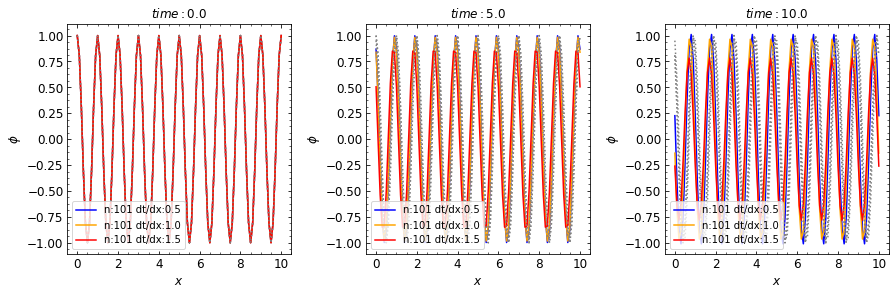

In [15]:
list_times = [0., 5., 10.]
list_dtdx = [0.5, 1., 1.5]
colors = ["blue", "orange", "red"]

list_resolutions = [101]
lss = ["-"]

res = {}

for dxdt in list_dtdx:
    res[dxdt] = {}
    for npoints in list_resolutions:
        res[dxdt][npoints] = {}
        x_arr, res_t, res_phi, _ = solve(N=npoints, ng=1, xmin=0., xmax=10., dtdx=dxdt, tmax=10.0)
        anal_final1 = analytcial_solution(x_arr, res_t)
        res[dxdt][npoints]["x_arr"] = x_arr
        res[dxdt][npoints]["res_t"] = res_t
        res[dxdt][npoints]["res_phi"] = res_phi
        res[dxdt][npoints]["phi_anal"] = anal_final1
# print("computed")

fig, axes = plt.subplots(nrows=1, ncols=len(list_times), sharey='all', figsize=(12.6, 4.2))
if len(list_times) == 1:
    axes = [axes]

for dxdt, color in zip(list_dtdx, colors):
    for npoints, ls in zip(list_resolutions, lss):
        
        x_arr = res[dxdt][npoints]["x_arr"]
        res_t = res[dxdt][npoints]["res_t"]
        res_phi = res[dxdt][npoints]["res_phi"]
        phi_anal = res[dxdt][npoints]["phi_anal"]
        #
        for ax, time in zip(axes, list_times):
            
            idx = find_nearest_index(res_t, time)
            x = x_arr
            phi = res_phi[idx]
            phi_a = phi_anal[idx]
            
            ax.plot(x, phi, color=color, ls=ls, label='n:{} dt/dx:{}'.format(npoints, dxdt))
            ax.plot(x, phi_a, color='gray', ls=':')#, label='n:{} dt/dx:{}'.format(npoints, dxdt))

for ax, time in zip(axes, list_times):
    ax.set_title("$time:{}$".format(time))
    ax.set_xlabel("$x$", fontsize='large')
    ax.set_ylabel("$\phi$", fontsize='large')
    ax.tick_params(
        axis='both', which='both', labelleft=True,
        labelright=False, tick1On=True, tick2On=True,
        labelsize=int(12),
        direction='in',
        bottom=True, top=True, left=True, right=True
    )
    ax.minorticks_on()
    ax.legend(loc="lower left", ncol=1)
plt.tight_layout()
# plt.subplots_adjust(hspace=0.2)
# plt.subplots_adjust(wspace=0.0)
# plt.savefig(FIGPATH + "profiles.png", dpi=128)
plt.show()

### Task 2 Self-convergence study

In [24]:
def self_convergence(num_phi1, num_phi2, num_phi4):

    print(len(num_phi1), len(num_phi2), len(num_phi4))

    num_phi2 = num_phi2[::2]
    num_phi4 = num_phi4[::4]
    diffs1 = []
    diffs2 = []
    norms = []
    for i in range(len(num_phi1)):
        sol_num = num_phi1[i]
        sol_num_2 = num_phi2[i]
        sol_num_4 = num_phi4[i]
        #
        diff1 = np.abs(sol_num - sol_num_2[::2])  # same length
        diff2 = np.abs(sol_num_2[::2] - sol_num_4[::4])#[::2]  # same length
        # print("self_conv diff1: {:d} diff2: {:d}".format(len(diff1), len(diff2)))
        #
        norm2 = np.log2(np.sqrt(np.sum(diff1 ** 2)) / np.sqrt(np.sum(np.abs(diff2 ** 2)))) # this is p
        #
        diffs1.append(diff1)
        diffs2.append(diff2)
        norms.append(norm2)
    return diffs1, diffs2, norms

(400, 800, 1600)
(200, 400, 800)
(134, 267, 534)


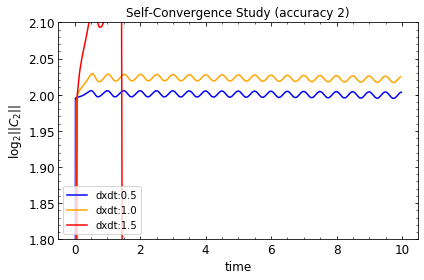

In [25]:
# solution at one reoslution
list_dtdx = [0.5, 1., 1.5]
colors = ["blue", "orange", "red"]
time_arrays = []
norm2_arrays = []
for dxdt in list_dtdx:
    x_arr, res_t, res_phi, _ = solve(N=101, ng=1, xmin=0., xmax=5., dtdx=dxdt, tmax=10.0)
    x_arr2, res_t2, res_phi2, _ = solve(N=201, ng=1, xmin=0., xmax=5., dtdx=dxdt, tmax=10.0)
    x_arr4, res_t4, res_phi4, _ = solve(N=401, ng=1, xmin=0., xmax=5., dtdx=dxdt, tmax=10.0)

    diffs1, diffs2, norms = self_convergence(res_phi, res_phi2, res_phi4)
        
    time_arrays.append(res_t)
    norm2_arrays.append(norms)


# plotting
fig, ax = plt.subplots(nrows=1, ncols=1)
for time_arr, norm2, color, dxdt in zip(time_arrays, norm2_arrays, colors, list_dtdx):
    ax.plot(time_arr, norm2, color=color, ls='-', label='dxdt:{}'.format(dxdt))

ax.set_xlabel("time", fontsize='large')
ax.tick_params(
    axis='both', which='both', labelleft=True,
    labelright=False, tick1On=True, tick2On=True,
    labelsize=int(12),
    direction='in',
    bottom=True, top=True, left=True, right=True
)
ax.set_ylabel("$\log_2 ||C_2||$", fontsize='large')
ax.minorticks_on()
ax.set_title("Self-Convergence Study (accuracy 2)")
ax.set_ylim(1.8, 2.1)
ax.legend(loc="lower left", ncol=1)
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.2)
# plt.savefig(FIGPATH + "self_convergence_dxdt.png", dpi=128)
plt.tight_layout()
plt.show()

### Task 3. Convergence Study

In [19]:
def convergence(anal_phi1, anal_phi2, num_phi1, num_phi2):

    #
    anal_phi2 = anal_phi2[::2]
    num_phi2 = num_phi2[::2]
    #
    diffs1 = []
    diffs2 = []
    norms = []
    for i, time in enumerate(anal_phi1):
        #
        # print("time:{} num_phi1:{} num_phi2:{}" .format(time, len(num_phi1[i]), len(num_phi2[i])))
        assert int(2 * len(num_phi1[i]) - 1) == len(num_phi2[i])
        #

        #
        sol_anal1 = anal_phi1[i]
        sol_anal2 = anal_phi2[i]
        sol_num = num_phi1[i]
        sol_num_2 = num_phi2[i]
        #
        diff1 = np.abs(sol_anal1 - sol_num)  # same length
        diff2 = np.abs(sol_anal2 - sol_num_2)[::2]  # same length
        # print("diff1: {:d} diff2: {:d}".format(len(diffs1), len(diffs2)))
        #
        norm2 = np.log2(np.sqrt(np.sum(diff1 ** 2)) / np.sqrt(np.sum(np.abs(diff2 ** 2))))
        #
        diffs1.append(diff1)
        diffs2.append(diff2)
        norms.append(norm2)
    return diffs1, diffs2, norms

/home/vsevolod/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in double_scalars


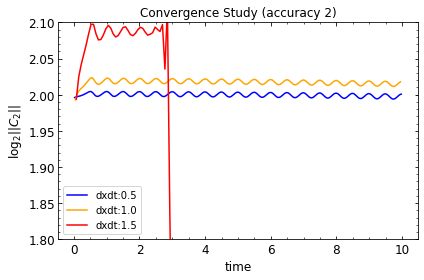

In [21]:
# solution at one reoslution
list_dtdx = [0.5, 1., 1.5]
colors = ["blue", "orange", "red"]
time_arrays = []
norm2_arrays = []
for dxdt in list_dtdx:
    x_arr, res_t, res_phi, _ = solve(N=101, ng=1, xmin=0., xmax=5., dtdx=dxdt, tmax=10.0)
    x_arr2, res_t2, res_phi2, _ = solve(N=201, ng=1, xmin=0., xmax=5., dtdx=dxdt, tmax=10.0)

    anal_final1 = analytcial_solution(x_arr, res_t)
    anal_final2 = analytcial_solution(x_arr2, res_t2)

    diffs1, diffs2, norms = convergence(anal_final1, anal_final2, res_phi, res_phi2)

    time_arrays.append(res_t)
    norm2_arrays.append(norms)
    
# plotting
fig, ax = plt.subplots(nrows=1, ncols=1)
for time_arr, norm2, color, dxdt in zip(time_arrays, norm2_arrays, colors, list_dtdx):
    ax.plot(time_arr, norm2, color=color, ls='-', label='dxdt:{}'.format(dxdt))


ax.set_xlabel("time", fontsize='large')

ax.tick_params(
    axis='both', which='both', labelleft=True,
    labelright=False, tick1On=True, tick2On=True,
    labelsize=int(12),
    direction='in',
    bottom=True, top=True, left=True, right=True
)
ax.set_ylabel("$\log_2 ||C_2||$", fontsize='large')
ax.minorticks_on()
ax.set_title("Convergence Study (accuracy 2)")
ax.legend(loc="lower left", ncol=1)
ax.set_ylim(1.8, 2.1)
plt.subplots_adjust(hspace=0.2)
plt.subplots_adjust(wspace=0.2)
# plt.savefig(FIGPATH + "convergence_dxdt.png", dpi=128)
plt.tight_layout()
# print("me")
plt.show()